In [12]:
import pandas as pd


df = pd.read_csv("diabetic_data.csv")

df.head()

# Show basic info
df.info()

# Quick stats for numerical columns
df.describe()

# Preview categories and missing values
print(df['readmitted'].value_counts())  # Target column
print(df.isna().sum())                  # Null values
print(df.columns)                       # All column names


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

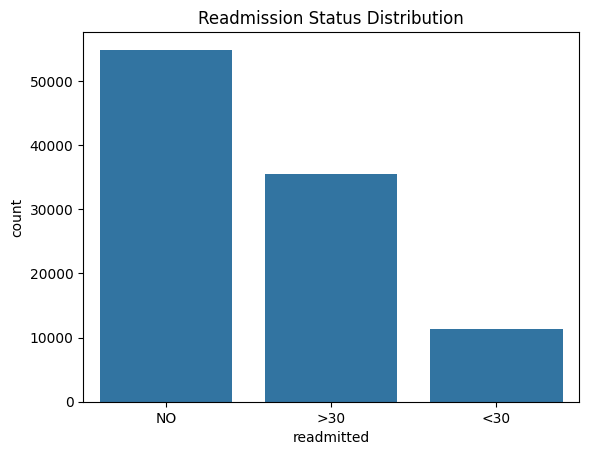

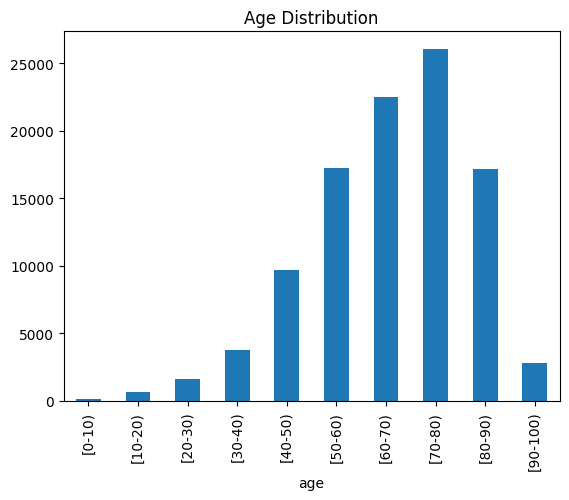

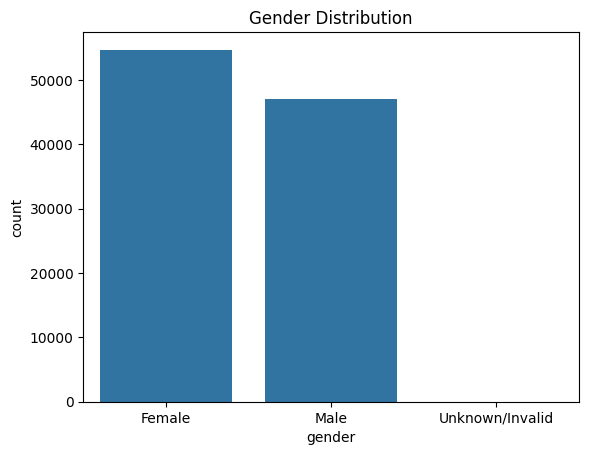

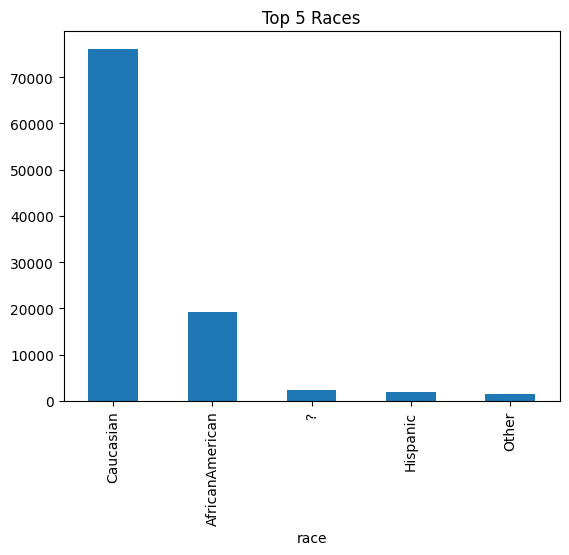

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot readmitted distribution
sns.countplot(x='readmitted', data=df)
plt.title('Readmission Status Distribution')
plt.show()

# Age distribution
df['age'].value_counts().sort_index().plot(kind='bar')
plt.title('Age Distribution')
plt.show()

# Gender count
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')
plt.show()

# Race distribution (top 5)
df['race'].value_counts().nlargest(5).plot(kind='bar')
plt.title('Top 5 Races')
plt.show()


In [14]:
# Replace '?' with NaN
df.replace('?', pd.NA, inplace=True)

# Check missing % for each column
missing_percent = df.isnull().mean() * 100
print(missing_percent[missing_percent > 0])

# Drop columns with very high missing values (e.g., > 70%)
drop_cols = missing_percent[missing_percent > 70].index
df.drop(columns=drop_cols, inplace=True)
print(f"Dropped columns: {drop_cols.tolist()}")

# For remaining columns, fill missing values or drop rows
df.fillna({'A1Cresult': 'None', 'max_glu_serum': 'None'}, inplace=True)

# Simplify target: combine >30 and <30 into one 'readmitted' class
df['readmitted'] = df['readmitted'].replace({'>30': 'YES', '<30': 'YES'})

# Encode target as binary
df['readmitted'] = df['readmitted'].map({'NO': 0, 'YES': 1})


race                  2.233555
weight               96.858479
payer_code           39.557416
medical_specialty    49.082208
diag_1                0.020636
diag_2                0.351787
diag_3                1.398306
max_glu_serum        94.746772
A1Cresult            83.277322
dtype: float64
Dropped columns: ['weight', 'max_glu_serum', 'A1Cresult']


In [15]:
from sklearn.preprocessing import LabelEncoder

# Get all object dtype columns except 'readmitted', safely
cat_cols = [col for col in df.select_dtypes(include='object').columns if col != 'readmitted']

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Prepare features and target
X = df.drop(columns=['readmitted', 'encounter_id', 'patient_nbr'])  # Drop ID columns
y = df['readmitted']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.6146703350692738
              precision    recall  f1-score   support

           0       0.61      0.79      0.69     10952
           1       0.63      0.41      0.49      9402

    accuracy                           0.61     20354
   macro avg       0.62      0.60      0.59     20354
weighted avg       0.62      0.61      0.60     20354



c:\Users\Suresh\anaconda3\envs\pipe\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
import joblib
import os

# After label encoding in notebook, before train_test_split:
X = df.drop(columns=['readmitted', 'encounter_id', 'patient_nbr'], errors='ignore')
y = df['readmitted']

# Save the column order that scaler will see
scaled_feature_columns = list(X.columns)

os.makedirs("models", exist_ok=True)
joblib.dump(scaled_feature_columns, "models/scaled_feature_columns.joblib")
print("Saved scaled_feature_columns.joblib with", len(scaled_feature_columns), "features.")


Saved scaled_feature_columns.joblib with 44 features.


In [17]:
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set experiment name (adjust username to your Databricks username)
experiment_name = "/Workspace/Users/parvathyk1805@gmail.com/Healthcare-Readmission-Tracking"
mlflow.set_experiment(experiment_name)

with mlflow.start_run():
    model = LogisticRegression(max_iter=3000, solver='saga')
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", acc)
    
    print(f"Accuracy: {acc}")
    print(classification_report(y_test, y_pred))
    
    # Log model with input example for signature inference
    input_example = X_test_scaled[:5]
    mlflow.sklearn.log_model(model, "logistic_regression_model", input_example=input_example)


2025/11/30 23:30:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Accuracy: 0.6162916380072713
              precision    recall  f1-score   support

           0       0.61      0.80      0.69     10952
           1       0.63      0.41      0.50      9402

    accuracy                           0.62     20354
   macro avg       0.62      0.60      0.59     20354
weighted avg       0.62      0.62      0.60     20354



In [18]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize Random Forest with some parameters
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

with mlflow.start_run():
    # Train model (use unscaled or scaled data as you prefer)
    rf_model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = rf_model.predict(X_test_scaled)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", acc)
    
    print(f"Accuracy: {acc}")
    print(classification_report(y_test, y_pred))
    
    # Log model with input example to infer signature
    input_example = X_test_scaled[:5]
    mlflow.sklearn.log_model(rf_model, "random_forest_model", input_example=input_example)


2025/11/30 23:30:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Accuracy: 0.6408568340375356
              precision    recall  f1-score   support

           0       0.64      0.75      0.69     10952
           1       0.64      0.52      0.57      9402

    accuracy                           0.64     20354
   macro avg       0.64      0.63      0.63     20354
weighted avg       0.64      0.64      0.64     20354



In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
import mlflow
import mlflow.sklearn
import numpy as np

# Parameter distribution for tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

with mlflow.start_run():
    random_search.fit(X_train_scaled, y_train)
    best_model = random_search.best_estimator_

    y_pred = best_model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", acc)
    print(f"Best params: {random_search.best_params_}")
    print(f"Accuracy: {acc}")
    print(classification_report(y_test, y_pred))
    
    mlflow.sklearn.log_model(best_model, "random_forest_model")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


2025/11/30 23:33:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 20, 'bootstrap': False}
Accuracy: 0.6438046575611673
              precision    recall  f1-score   support

           0       0.66      0.69      0.67     10952
           1       0.62      0.59      0.61      9402

    accuracy                           0.64     20354
   macro avg       0.64      0.64      0.64     20354
weighted avg       0.64      0.64      0.64     20354



2025/11/30 23:33:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [21]:
import os
import mlflow
import mlflow.sklearn
import joblib
import pandas as pd

# ==== 1. Define names and paths ====
model_name = "Healthcare_Readmission_RF"
models_dir = "models"
os.makedirs(models_dir, exist_ok=True)

model_path = os.path.join(models_dir, "best_rf_model.joblib")
scaler_path = os.path.join(models_dir, "scaler.joblib")
feature_cols_path = os.path.join(models_dir, "feature_columns.joblib")

# ==== 2. Log model with signature to current MLflow run ====
from mlflow.models.signature import infer_signature

# Use a small sample to infer signature
X_sample = X_test_scaled[:100]
y_sample = y_test.iloc[:100]

signature = infer_signature(X_sample, best_model.predict(X_sample))

with mlflow.start_run(nested=True):
    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="random_forest_model_v2",
        signature=signature,
        input_example=X_sample
    )
    mlflow.log_param("model_name", model_name)
    print("Model with signature logged to MLflow.")

# Optionally register the model (if you have Model Registry available)
try:
    run_id = mlflow.active_run().info.run_id
except Exception:
    run_id = None

if run_id is not None:
    model_uri = f"runs:/{run_id}/random_forest_model_v2"
    try:
        registered_model = mlflow.register_model(model_uri=model_uri, name=model_name)
        print(f"Registered model in MLflow Model Registry as: {model_name}")
    except Exception as e:
        print("Model Registry registration skipped or failed:", e)

# ==== 3. Save artifacts locally for deployment (FastAPI/Streamlit) ====
# Save trained model
joblib.dump(best_model, model_path)
# Save scaler (must be defined from earlier preprocessing)
joblib.dump(scaler, scaler_path)
# Save feature column order used during training
joblib.dump(list(X_encoded.columns), feature_cols_path)

print("Local artifacts saved:")
print("  Model:", model_path)
print("  Scaler:", scaler_path)
print("  Feature columns:", feature_cols_path)


2025/11/30 23:34:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model with signature logged to MLflow.
Local artifacts saved:
  Model: models\best_rf_model.joblib
  Scaler: models\scaler.joblib
  Feature columns: models\feature_columns.joblib
